In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
def process_log_easy(file="data_logs_players/log_1_easy.csv"):
    df = pd.read_csv(file)
    results = df.at[len(df)-1, "Unnamed: 0"].split()  # result logged as "Killed: X Saved: Y" in first column
    killed, saved = map(int, [results[1], results[3]])
    df = df.drop(["Unnamed: 0", "humanoid_fp", "humanoid_probs", "local_run_id"], axis=1)
    df = df.dropna()
    return df, killed, saved

In [3]:
def process_log_hard(file="data_logs_players/log_2_hard.csv"):
    df = pd.read_csv(file)
    results = df.at[len(df)-1, "Unnamed: 0"].split()  # result logged as "Killed: X Saved: Y" in first column
    killed, saved = map(int, [results[1], results[3]])
    df = df.drop(["Unnamed: 0", "humanoid_fp", "local_run_id"], axis=1)
    df = df.dropna()
    df["highest_prob"] = df["humanoid_probs"]
    df["highest_prob"] = df["highest_prob"].map(eval)
    df["highest_prob"] = df["highest_prob"].map(lambda d: sorted(d, key=lambda x: d[x], reverse=True)[0])
    return df, killed, saved

In [4]:
def get_combined_data(folder):
    easy_scores, hard_scores = [], []
    easy_data, hard_data = pd.DataFrame(), pd.DataFrame()
    for file in os.listdir(folder):
        if "easy" in file:
            log, killed, saved = process_log_easy(os.path.join(folder, file))
            easy_data = pd.concat([easy_data, log])
            easy_scores.append((killed, saved))
        elif "hard" in file:
            log, killed, saved = process_log_hard(os.path.join(folder, file))
            hard_data = pd.concat([hard_data, log])
            hard_scores.append((killed, saved))
    return easy_scores, hard_scores, easy_data, hard_data


In [5]:
es, hs, ed, hd = get_combined_data("data_logs_players")

In [6]:
# can we even get useful info out of this :P

easy_scores = sorted([s - k for (k, s) in es])
hard_scores = sorted([s - k for (k, s) in hs])

print(easy_scores)
print(pd.Series(easy_scores).describe())
print()
print(hard_scores)
print(pd.Series(hard_scores).describe())

[-20, -13, 2, 12, 13, 16, 19, 30]
count     8.000000
mean      7.375000
std      16.766783
min     -20.000000
25%      -1.750000
50%      12.500000
75%      16.750000
max      30.000000
dtype: float64

[-12, -11, -7, 0, 4, 6, 9, 10, 11]
count     9.000000
mean      1.111111
std       9.061518
min     -12.000000
25%      -7.000000
50%       4.000000
75%       9.000000
max      11.000000
dtype: float64


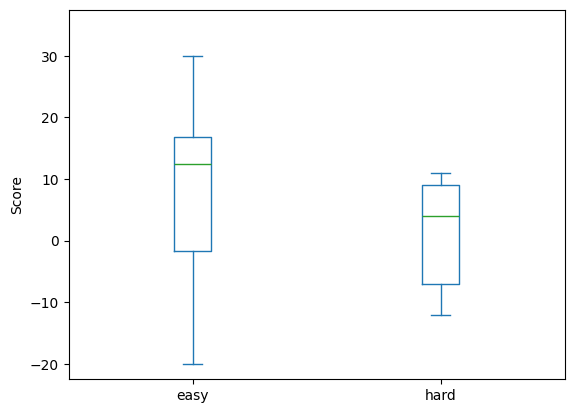

In [7]:
score_data = pd.concat([pd.Series(easy_scores), pd.Series(hard_scores)], axis=1)
score_data = score_data.rename(columns={0:"easy", 1:"hard"})
ax = score_data.plot.box()
ax.set_ylabel("Score")
ax.set_ybound(-22.5, 37.5)
# print(ax.get_ybound())
plt.show()

<Axes: >

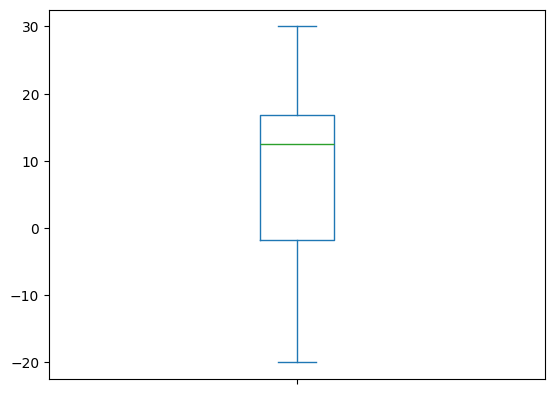

In [8]:
pd.Series(easy_scores).plot.box()

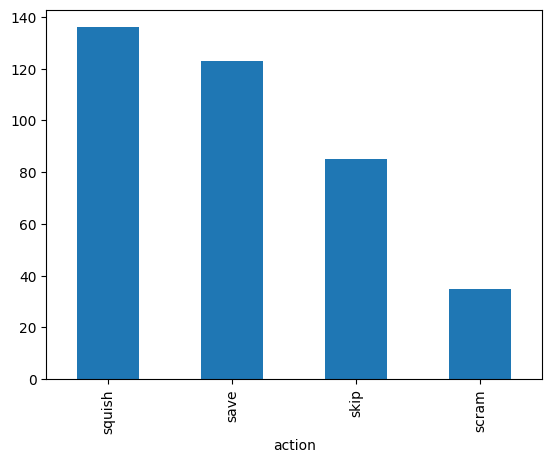

In [9]:
action_dist_easy = ed["action"].value_counts()
ax = action_dist_easy.plot.bar()

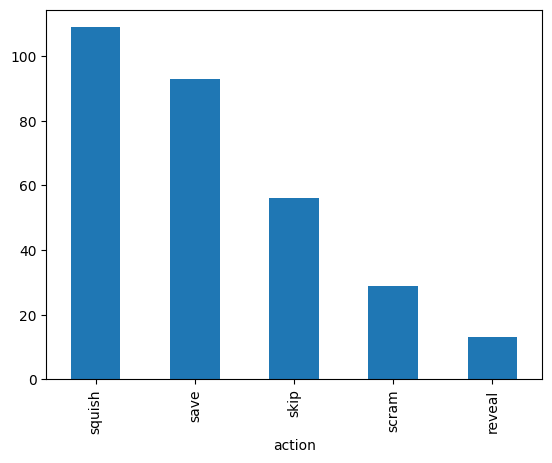

In [10]:
action_dist_hard = hd["action"].value_counts()
ax = action_dist_hard.plot.bar()

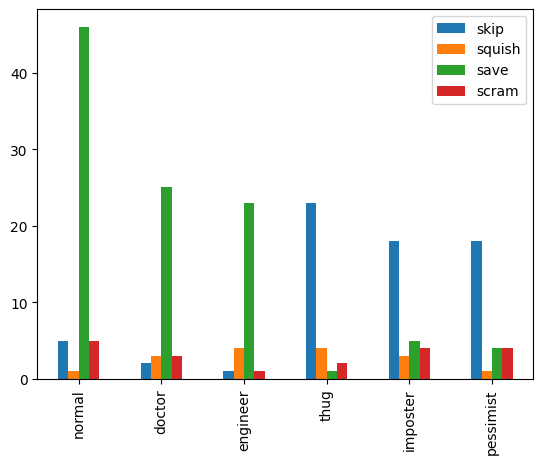

In [33]:
# action distribution by job (human, easy)
human_action_dist_easy = pd.DataFrame(0, index=["normal", "doctor", "engineer", "thug", "imposter", "pessimist"],
                                             columns=["skip", "squish", "save", "scram"])
for action in ed.itertuples(index=False):
    if action.humanoid_class == "healthy":
        human_action_dist_easy.loc[action.humanoid_job, action.action] += 1

ax = human_action_dist_easy.plot.bar()

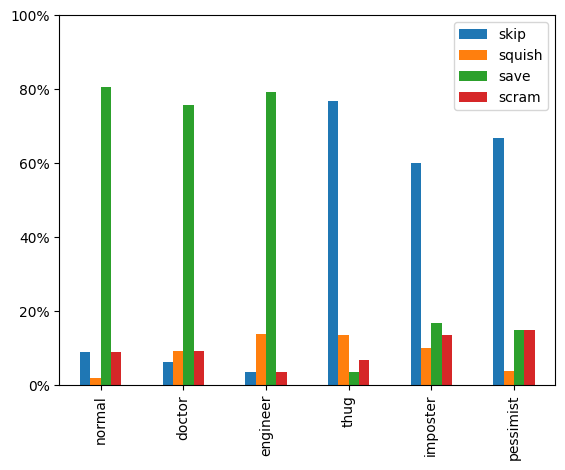

In [34]:
# normalize human_action_dist_easy to percentages
row_sums = human_action_dist_easy.sum(axis=1)
res = human_action_dist_easy.div(row_sums, axis=0)
ax = res.plot.bar()
# print(ax.get_ybound())
ax.set_ybound(0.0, 1.0)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
plt.show()


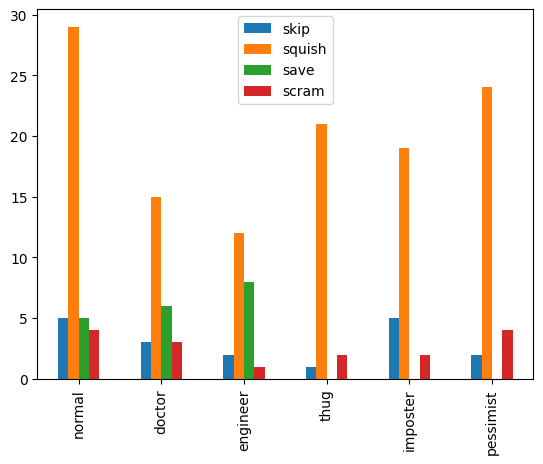

In [35]:
# same but for zombies 
zombie_action_dist_easy = pd.DataFrame(0, index=["normal", "doctor", "engineer", "thug", "imposter", "pessimist"],
                                             columns=["skip", "squish", "save", "scram"])
for action in ed.itertuples(index=False):
    if action.humanoid_class == "zombie":
        zombie_action_dist_easy.loc[action.humanoid_job, action.action] += 1

ax = zombie_action_dist_easy.plot.bar()

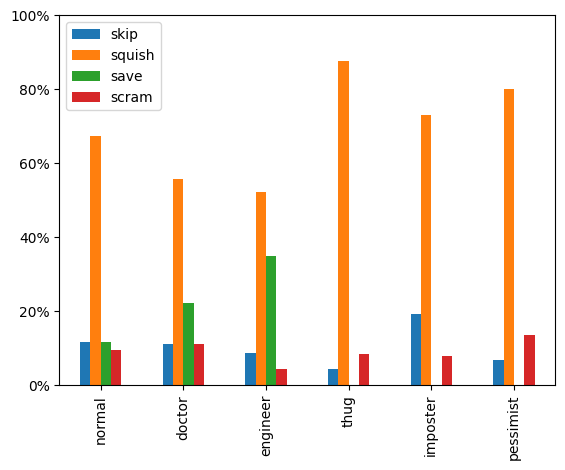

In [36]:
# normalize zombie_action_dist_easy to percentages
row_sums = zombie_action_dist_easy.sum(axis=1)
res = zombie_action_dist_easy.div(row_sums, axis=0)
ax = res.plot.bar()
# print(ax.get_ybound())
ax.set_ybound(0.0, 1.0)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
plt.show()


<Axes: >

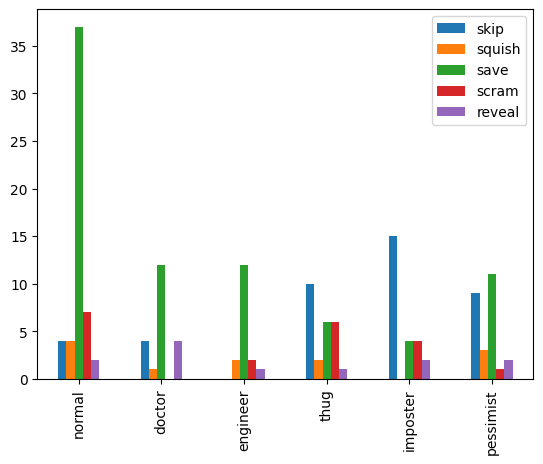

In [13]:
# action distribution by job (human, hard)
human_action_dist_hard = pd.DataFrame(0, index=["normal", "doctor", "engineer", "thug", "imposter", "pessimist"],
                                             columns=["skip", "squish", "save", "scram", "reveal"])
for action in hd.itertuples(index=False):
    if action.humanoid_class == "healthy":
        human_action_dist_hard.loc[action.humanoid_job, action.action] += 1

human_action_dist_hard.plot.bar()

<Axes: >

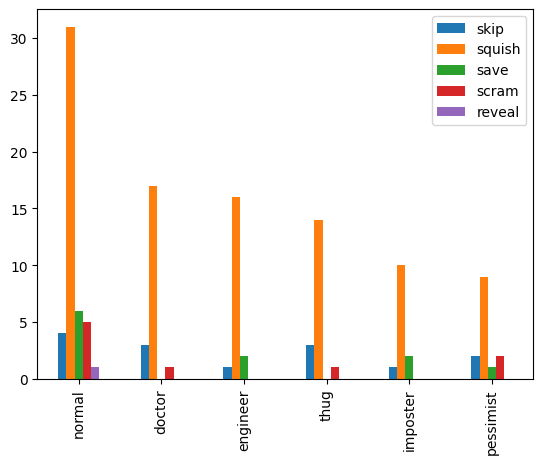

In [14]:
# same but for zombies 
zombie_action_dist_hard = pd.DataFrame(0, index=["normal", "doctor", "engineer", "thug", "imposter", "pessimist"],
                                             columns=["skip", "squish", "save", "scram", "reveal"])
for action in hd.itertuples(index=False):
    if action.humanoid_class == "zombie":
        zombie_action_dist_hard.loc[action.humanoid_job, action.action] += 1

zombie_action_dist_hard.plot.bar()

<Axes: >

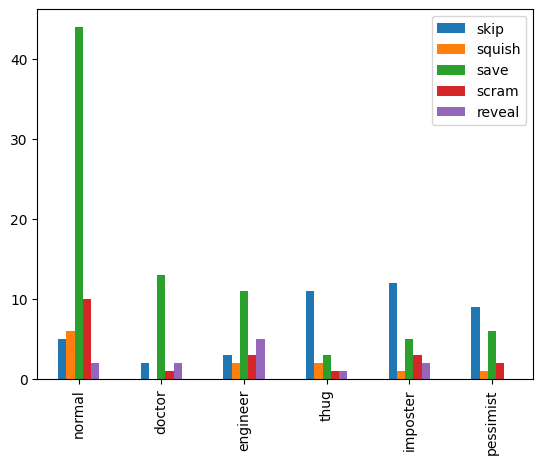

In [15]:
# action distribution by highest prob (human, hard)
human_action_dist_hard = pd.DataFrame(0, index=["normal", "doctor", "engineer", "thug", "imposter", "pessimist"],
                                             columns=["skip", "squish", "save", "scram", "reveal"])
for action in hd.itertuples(index=False):
    # print(action)
    if action.humanoid_class == "healthy":
        human_action_dist_hard.loc[action.highest_prob, action.action] += 1

human_action_dist_hard.plot.bar()

<Axes: >

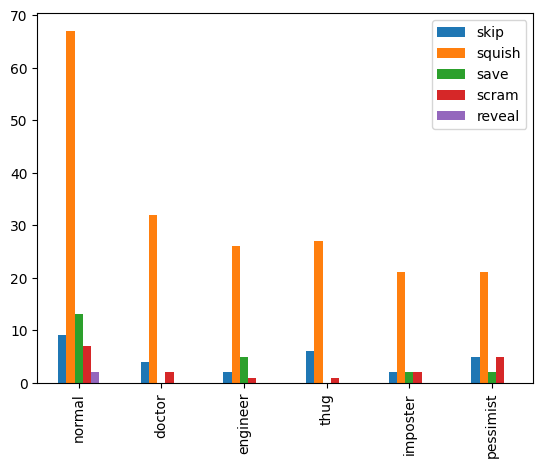

In [16]:
# action distribution by highest prob (zombie, hard)
zombie_action_dist_hard_action_dist_hard = pd.DataFrame(0, index=["normal", "doctor", "engineer", "thug", "imposter", "pessimist"],
                                             columns=["skip", "squish", "save", "scram", "reveal"])
for action in hd.itertuples(index=False):
    # print(action)
    if action.humanoid_class == "zombie":
        zombie_action_dist_hard.loc[action.highest_prob, action.action] += 1

zombie_action_dist_hard.plot.bar()